# Description

Goal: score-vs-parameters(speed,k,x0,radius) exploration for dVGFdF11
Method:
    1. fit a function for x0,radius,k such that all three can be represented as one.
        and also be able to inverse it rather easily, ofc not bijective, but good enough.
    2. interpolate the score given the two parameters. two because easier two visualize. 
        but you can also directly fit the score to the 4 paramerters and evaluate a funciton this way.
    3. contour plot.

In [85]:
import pandas as pd
from utils import *

eval_csv = "/Users/ashkanhzdr/workspace/infectio-mesa/output/dVGFdF11/0_evaluation/bulk_evaluate.csv"

df = read_and_clean_df(eval_csv)
df = add_param_cols_from_experiment_name(df)

df[["c2c_x0", "c2c_k", "c2c_radius"]].describe()

c2c_x0        c2c_k   c2c_radius
count  2106.000000  2106.000000  2106.000000
mean     14.525641    12.611301    18.642925
std      16.956912    17.006931    16.643467
min       1.000000     0.100000     2.000000
25%       2.000000     0.500000     5.000000
50%       5.000000     5.000000    10.000000
75%      20.000000    25.000000    30.000000
max      50.000000    50.000000    50.000000

# Step 1: Parameter Reduction: polynomial + Linear Regression

In [86]:
r = 20
np.pi * r ** 2 * 0.00042674374678497944 * (3.1746**2)

5.404494184152684

#### Note
Below you can change DEGREE and INCLUDE_BIAS to change polynomial

In [87]:
DEGREE = 2
INCLUDE_BIAS = False

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# Assume you have data arrays: x0_values, k_values, r_values, and infection_collective_parameters
x0_values = np.linspace(0, 50, 1000)
k_values = np.linspace(0, 50, 1000)
r_values = np.linspace(0, 50, 1000)

def c2c_collective(x0, k, radius):
    num_infected_neighbors = np.pi * radius ** 2 * 0.00042674374678497944 * (3.1746**2)
    if num_infected_neighbors == 0:
        return 0.0
    return 1 / (1 + np.exp(-k * (num_infected_neighbors - x0)))

infection_collective_parameters = np.array([c2c_collective(xx, kk, rr) for xx, kk, rr in zip(x0_values, k_values, r_values)])

# Step 1: Combine x0, k, and r into a single matrix of features
X = np.column_stack((x0_values, k_values, r_values))

# Step 2: Create polynomial features up to degree 2 (you can adjust degree as needed)
poly = PolynomialFeatures(degree=DEGREE, include_bias=INCLUDE_BIAS)
X_poly = poly.fit_transform(X)  # This creates polynomial terms for the features

# Step 3: Fit a linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, infection_collective_parameters)

# Step 4: Define a function for predicting the infection_collective_parameter using the fitted polynomial model
def predict_infection_parameter(x0, k, r):
    features = np.array([[x0, k, r]])
    poly_features = poly.transform(features)  # Transform to polynomial features
    return model.predict(poly_features)[0]    # Predict the infection collective parameter

# Example of predicting the infection parameter for new values of x0, k, r
x0_new, k_new, r_new = 2.5, 0.4, 8.0
predicted_param = predict_infection_parameter(x0_new, k_new, r_new)
print(f"Predicted infection collective parameter for (x0={x0_new}, k={k_new}, r={r_new}): {predicted_param}")

Predicted infection collective parameter for (x0=2.5, k=0.4, r=8.0): 0.06591767277654476


/var/folders/34/7vrvs7ts667_lxxqxdk42tlh0000gp/T/ipykernel_17925/2914013583.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (num_infected_neighbors - x0)))


# Step 2: Fit Score function to speed and c2c_c

In [88]:
rw_speed = df["randomwalk_speed"].values
c2c = df[["c2c_x0", "c2c_k", "c2c_radius"]].values  # _c stands for collective
c2c_c = np.array([predict_infection_parameter(x0, k, r) for x0, k, r in c2c])

## Method: Piecewise Linear

In [89]:
import numpy as np
from scipy.interpolate import griddata

def plot_piecewise_linear_interpolator(scorename, method='linear', xlim=None, ylim=None):
    score = df[scorename].values
    
    # Generate a grid of points to interpolate the score over
    grid_x, grid_y = np.mgrid[rw_speed.min():rw_speed.max():100j, c2c_c.min():c2c_c.max():100j]
    interpolated_scores = griddata((rw_speed, c2c_c), score, (grid_x, grid_y), method=method)

    # Create a 2D contour plot of the interpolated score
    plt.figure(figsize=(10, 8))
    
    # Contour plot with the first colormap
    contour = plt.contourf(grid_x, grid_y, interpolated_scores, levels=20, cmap='viridis')

    # Scatter plot with a second colormap based on score values
    scatter = plt.scatter(rw_speed, c2c_c, c=score, cmap='magma', s=30, edgecolor='white', alpha=1)

    # Add the first colorbar (for the contour plot)
    plt.colorbar(contour, label='Interpolated Score')

    # Add the second colorbar (for the scatter plot)
    cbar_scatter = plt.colorbar(scatter, label=scorename + ' Sample Score')
    
    # Customize plot details
    plt.title(scorename + ' interpolated with Piecewiselinear(' + method + ') and Sampled Points')
    plt.xlabel('randomwalk_speed')
    plt.ylabel('c2c Collective Component')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.show()

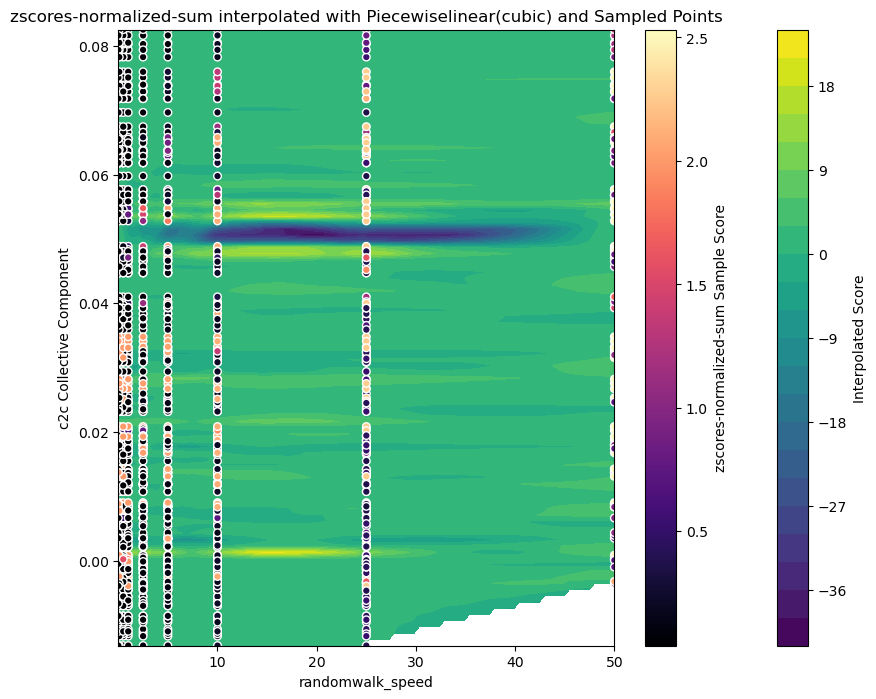

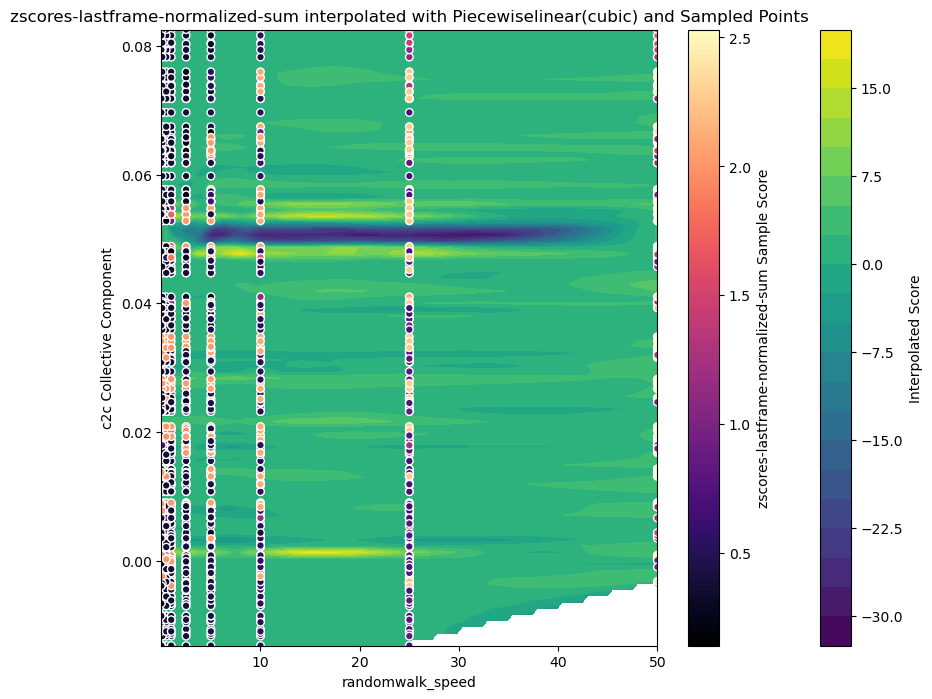

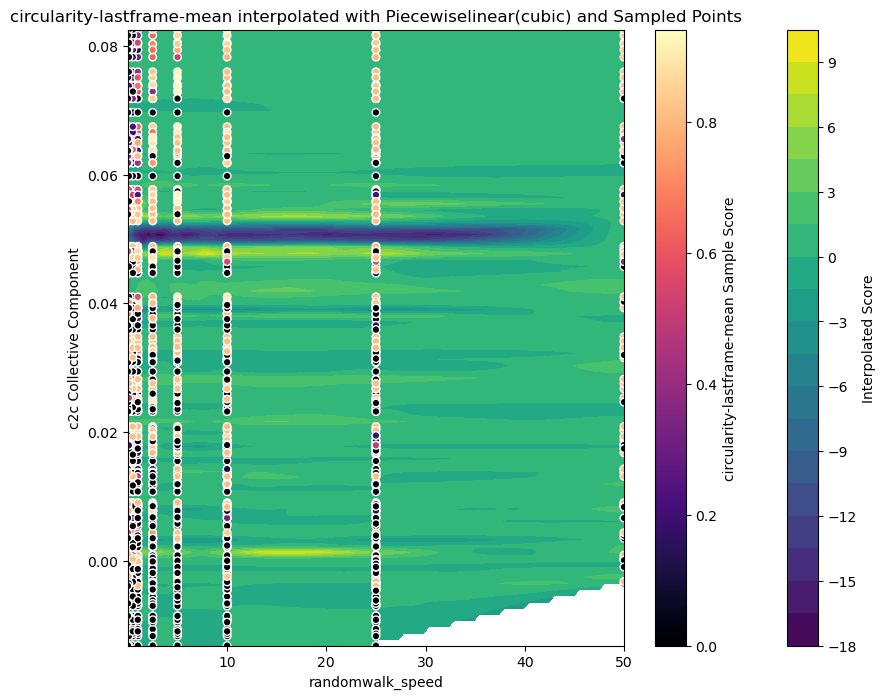

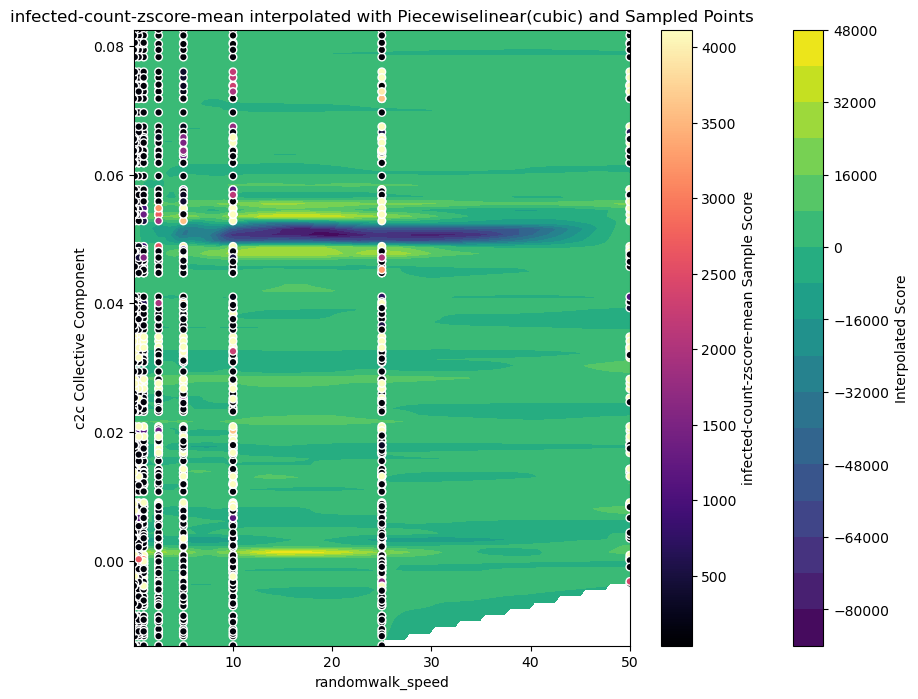

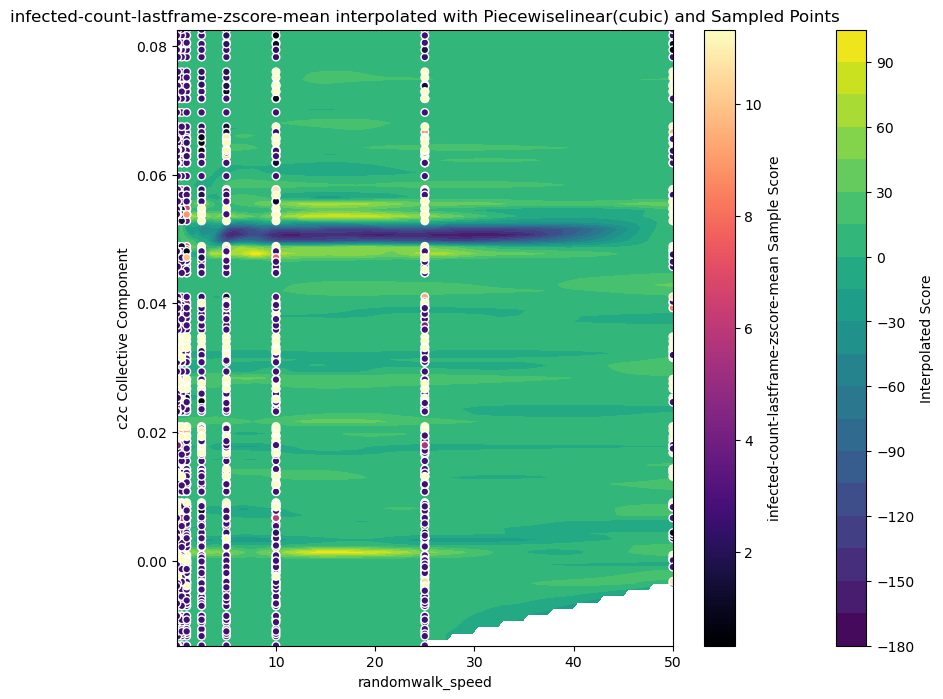

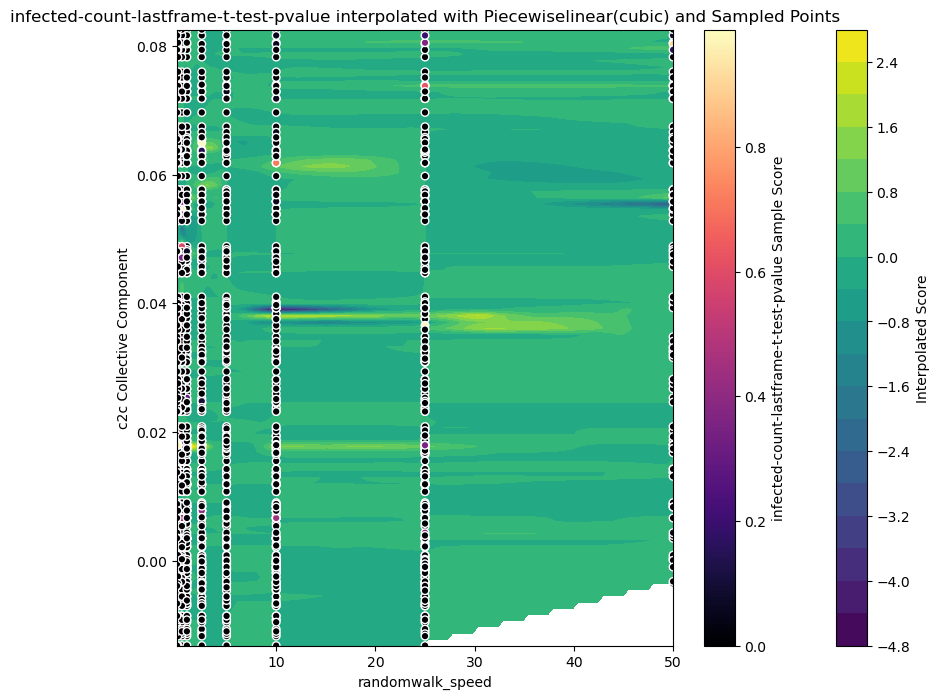

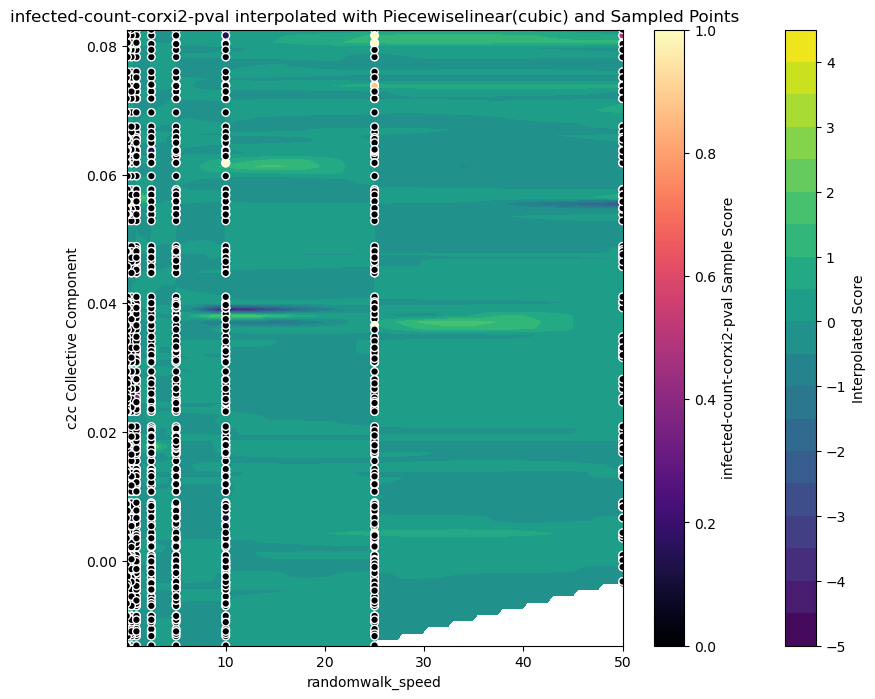

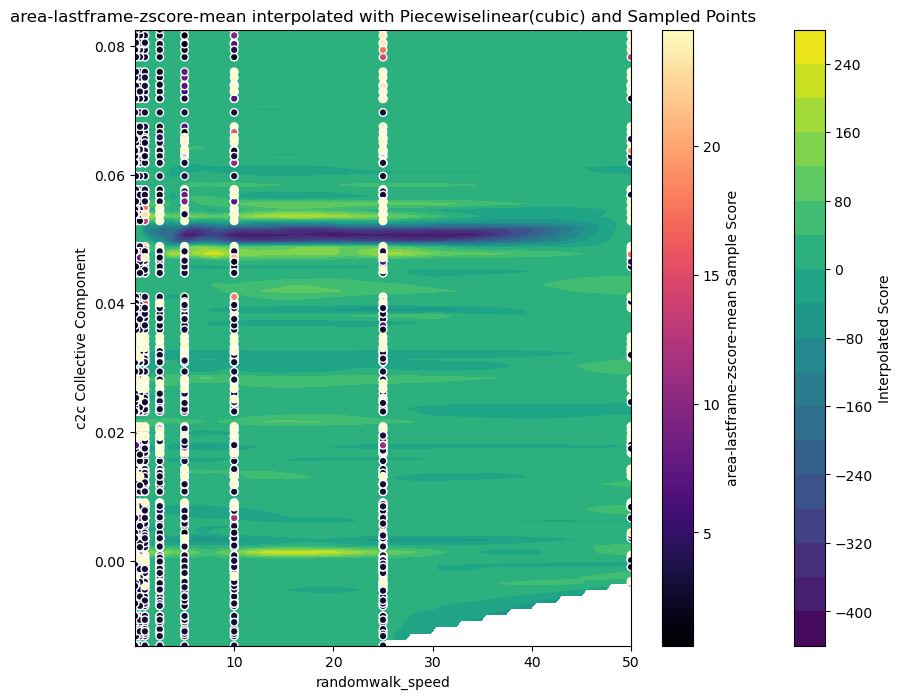

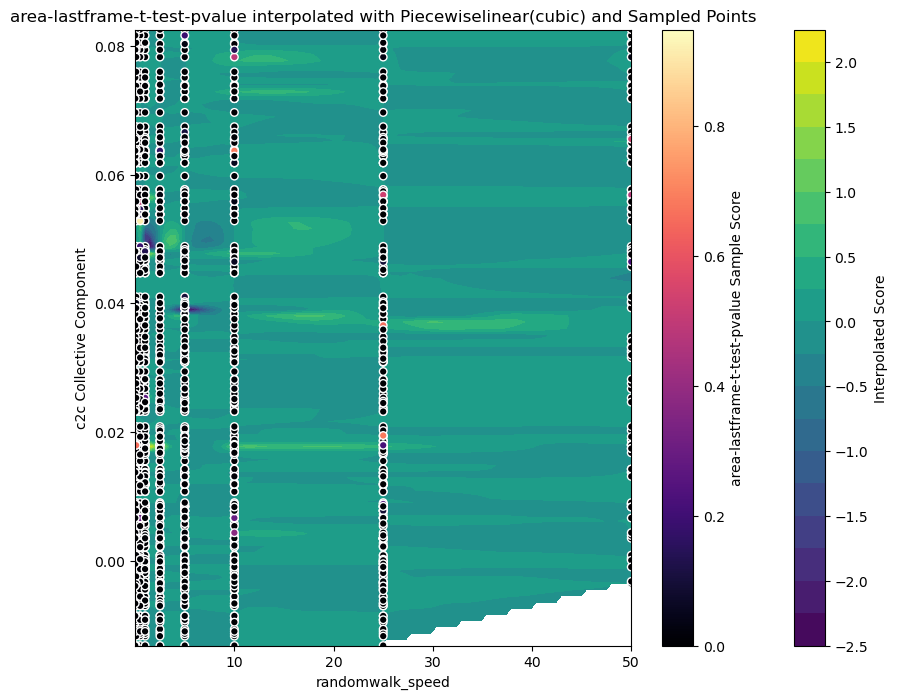

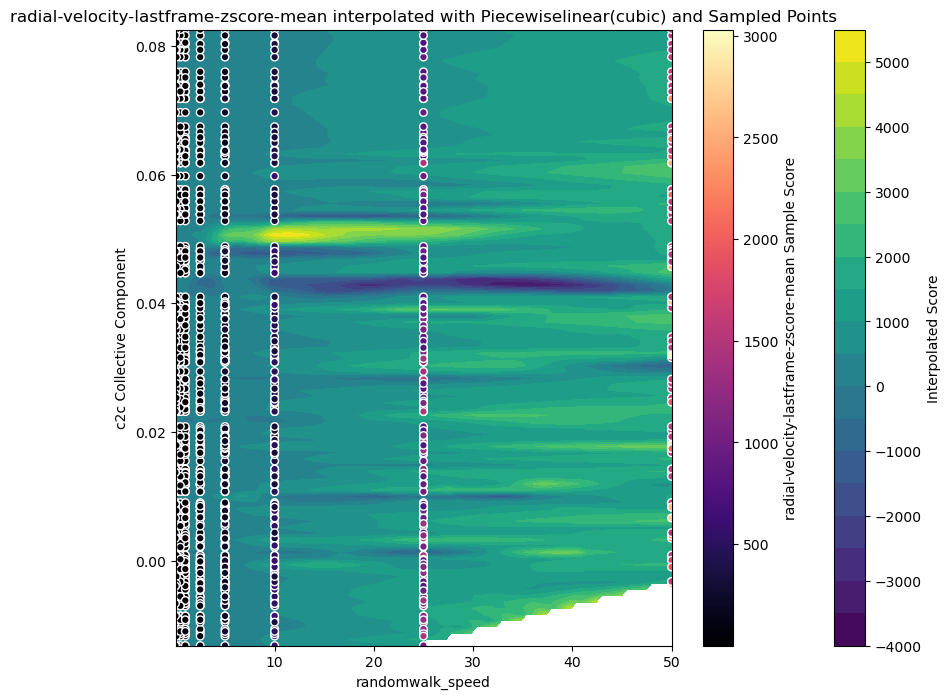

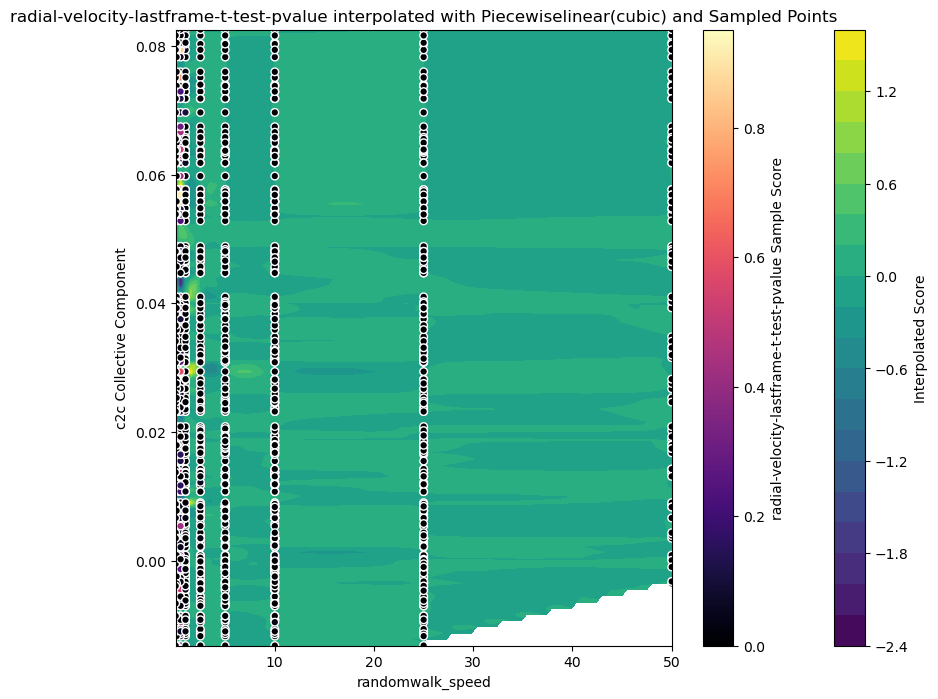

In [90]:
scorenames = ["zscores-normalized-sum", "zscores-lastframe-normalized-sum", "circularity-lastframe-mean", "infected-count-zscore-mean", "infected-count-lastframe-zscore-mean", "infected-count-lastframe-t-test-pvalue", "infected-count-corxi2-pval", "area-lastframe-zscore-mean", "area-lastframe-t-test-pvalue", "radial-velocity-lastframe-zscore-mean", "radial-velocity-lastframe-t-test-pvalue"]
for s in scorenames:
    plot_piecewise_linear_interpolator(s, method='cubic')  # methods: nearest, linear, cubic

## Method: RBF


In [91]:
import numpy as np
from scipy.interpolate import RBFInterpolator

def plot_rbf_interpolator(scorename, method, epsilon=1, xlim=None, ylim=None):
    score = df[scorename].values
    points = np.vstack((rw_speed, c2c_c)).T
    rbf_interpolator = RBFInterpolator(points, score, kernel=method, epsilon=epsilon)

    # Generate a grid of points to interpolate the score over
    grid_x, grid_y = np.mgrid[rw_speed.min():rw_speed.max():100j, c2c_c.min():c2c_c.max():100j]
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Evaluate the interpolator on the grid
    interpolated_scores = rbf_interpolator(grid_points).reshape(grid_x.shape)

    # Create a 2D contour plot of the interpolated score
    plt.figure(figsize=(10, 8))
    
    # Contour plot with the first colormap
    contour = plt.contourf(grid_x, grid_y, interpolated_scores, levels=20, cmap='viridis')

    # Scatter plot with a second colormap based on score values
    scatter = plt.scatter(rw_speed, c2c_c, c=score, cmap='magma', s=30, edgecolor='white', alpha=1)

    # Add the first colorbar (for the contour plot)
    plt.colorbar(contour, label='Interpolated Score')

    # Add the second colorbar (for the scatter plot)
    cbar_scatter = plt.colorbar(scatter, label=scorename + ' Sample Score')
    
    # Customize plot details
    plt.title(scorename + ' interpolated with RBF(kernel=' + method + ') and Sampled Points')
    plt.xlabel('randomwalk_speed')
    plt.ylabel('c2c Collective Component')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.show()

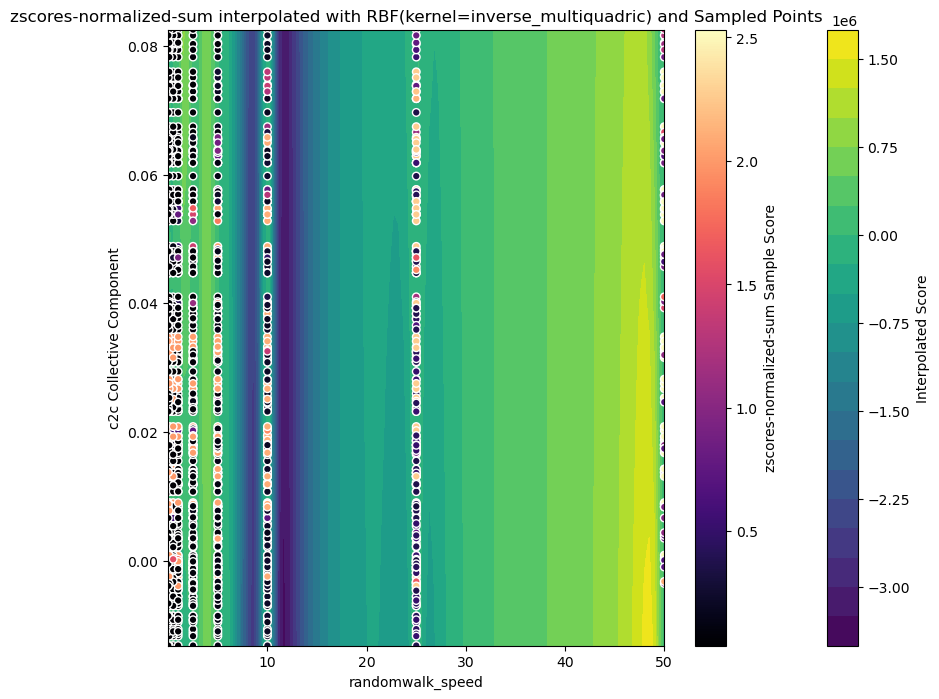

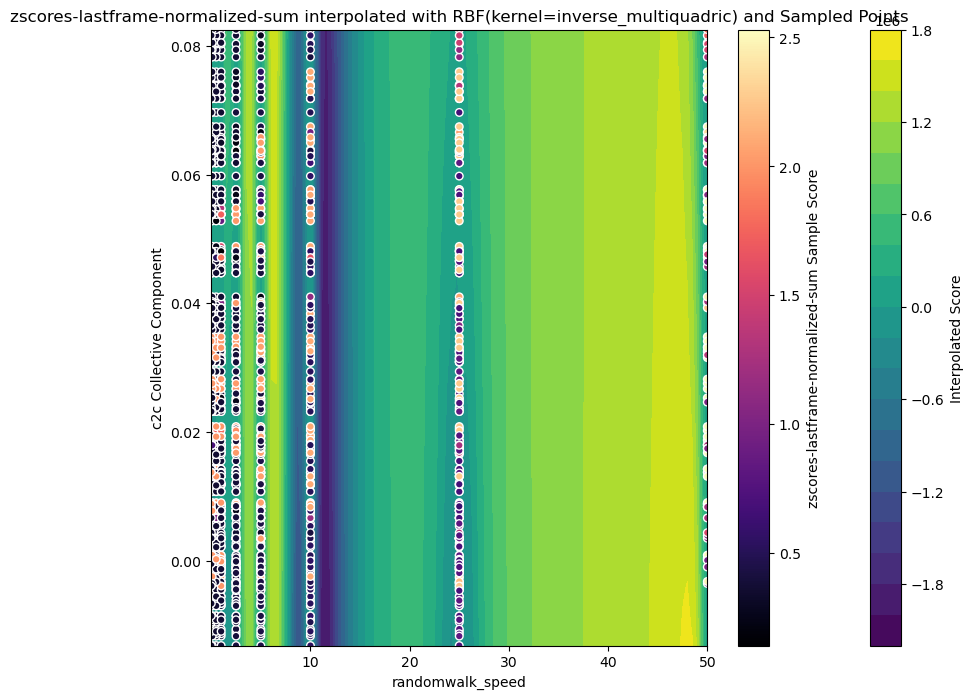

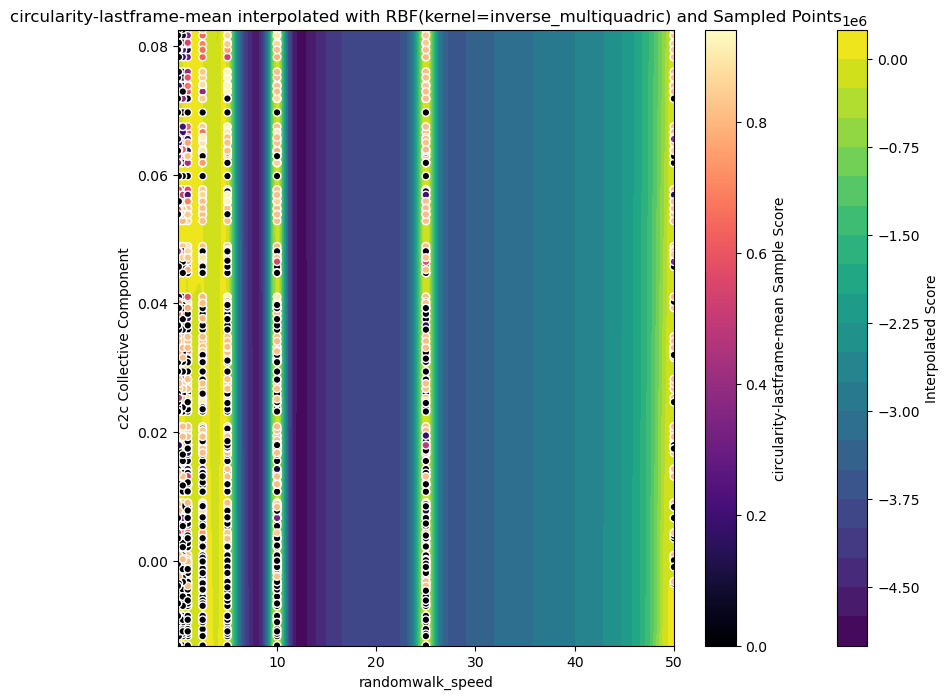

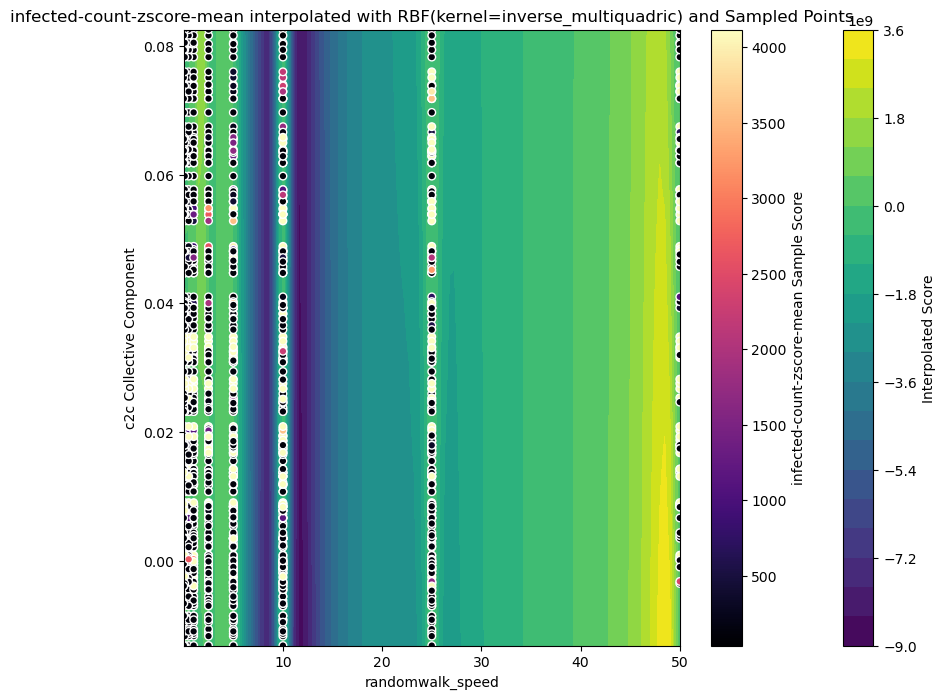

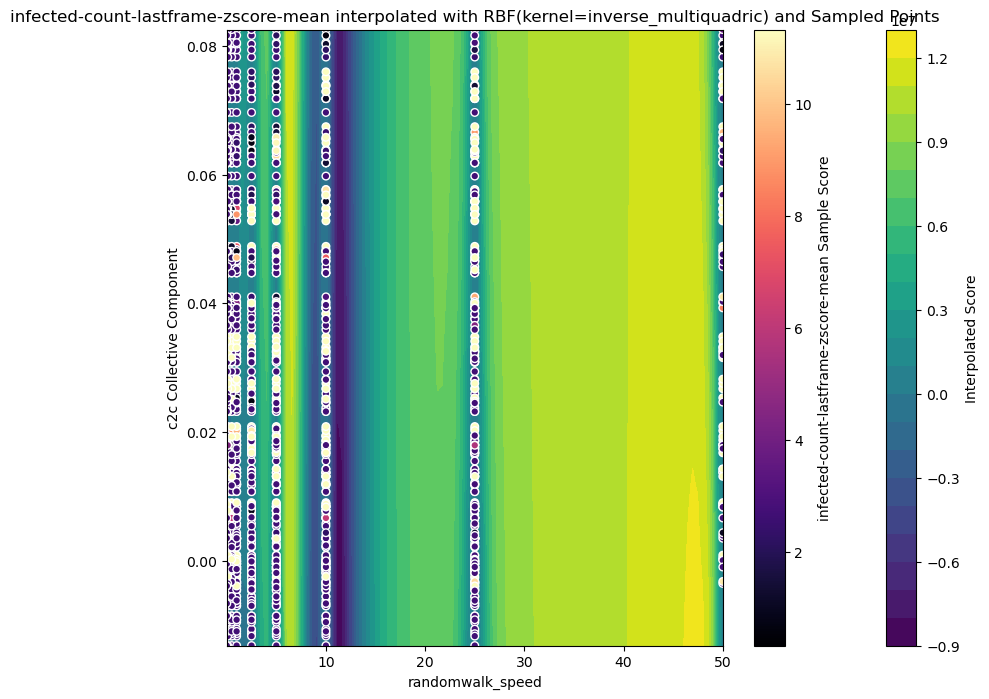

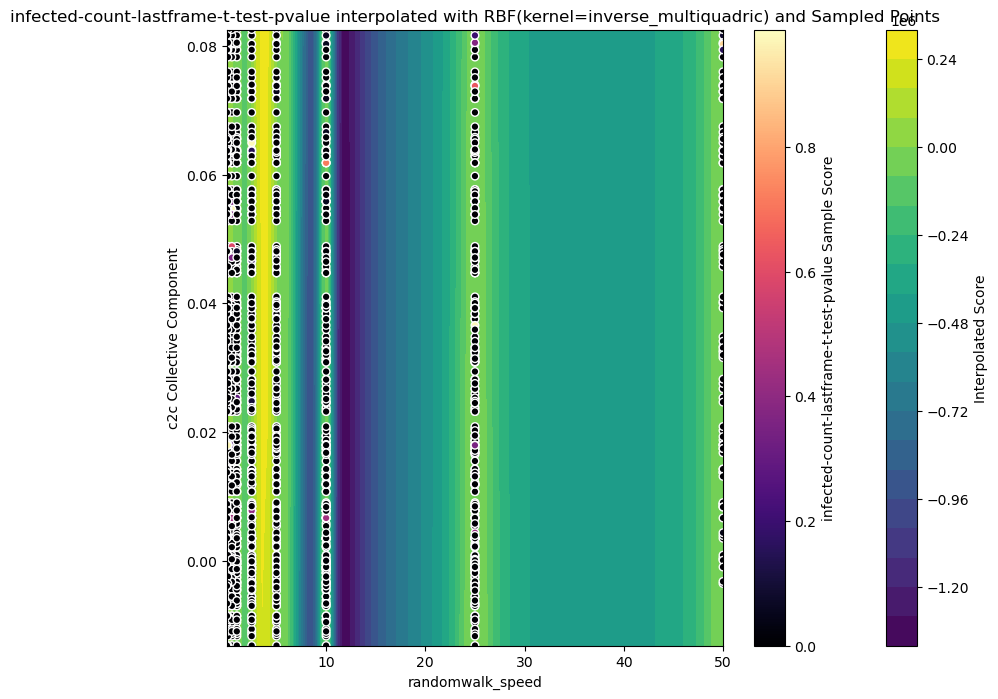

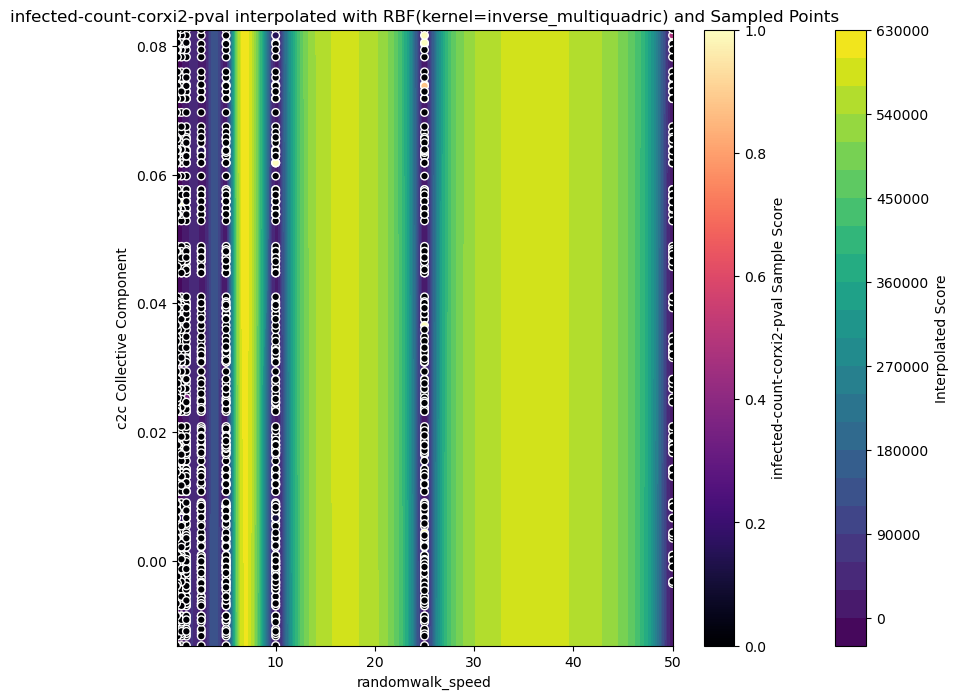

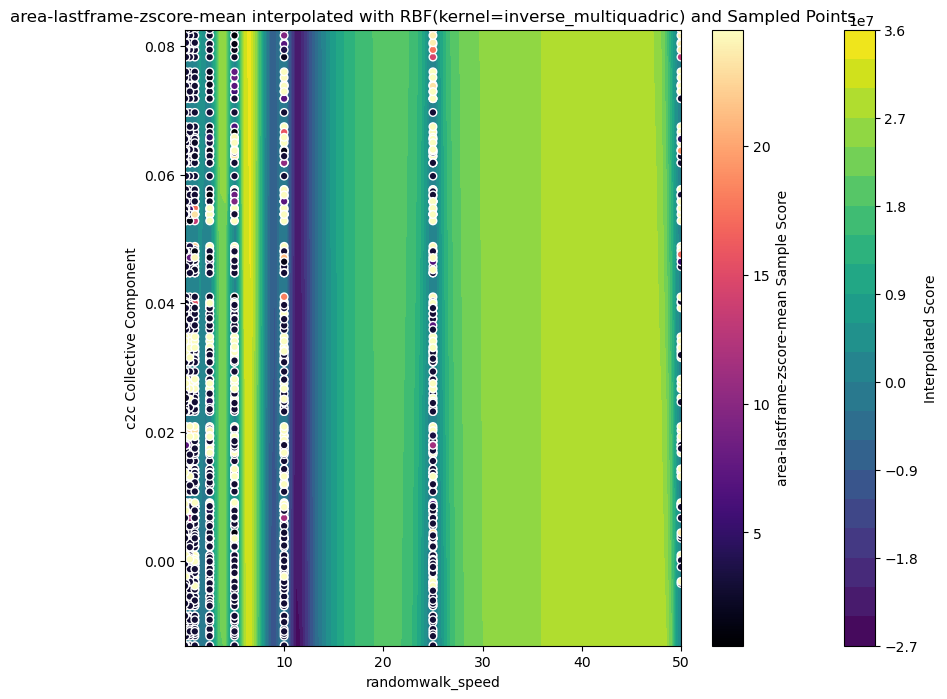

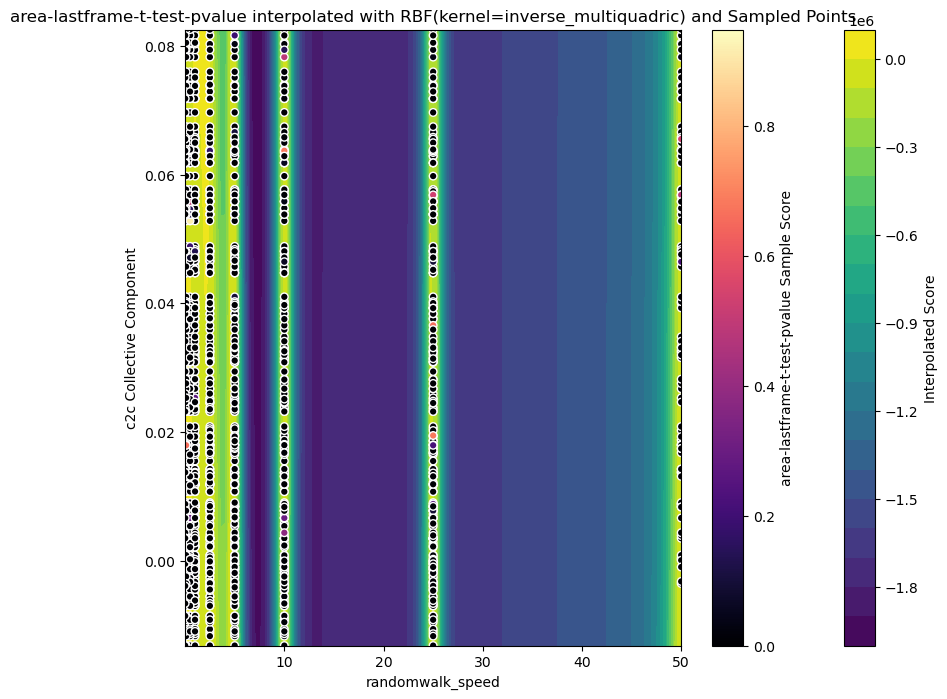

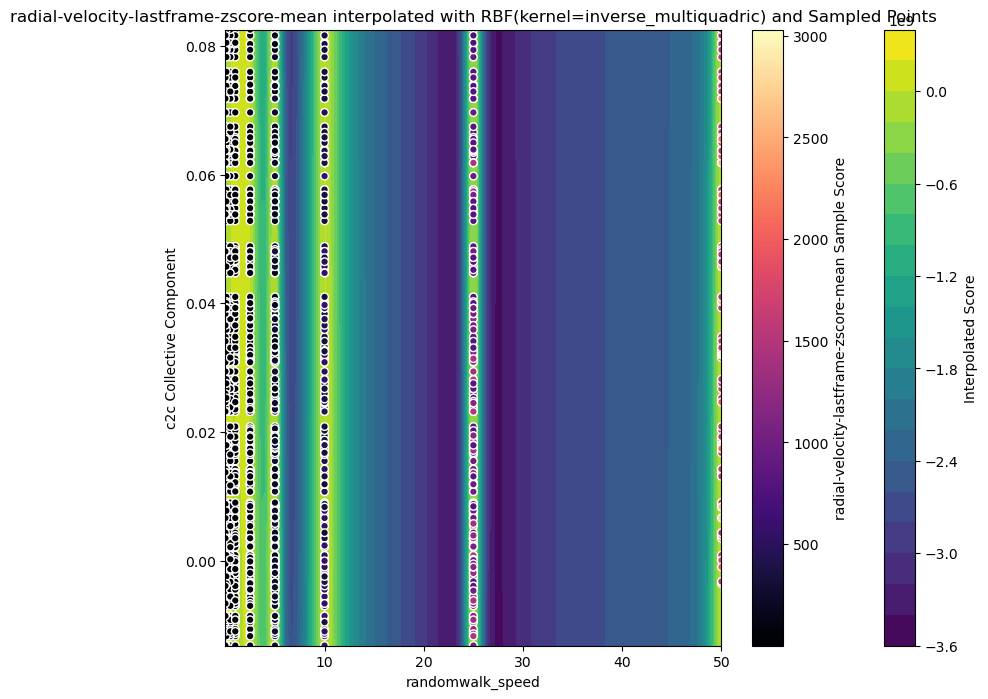

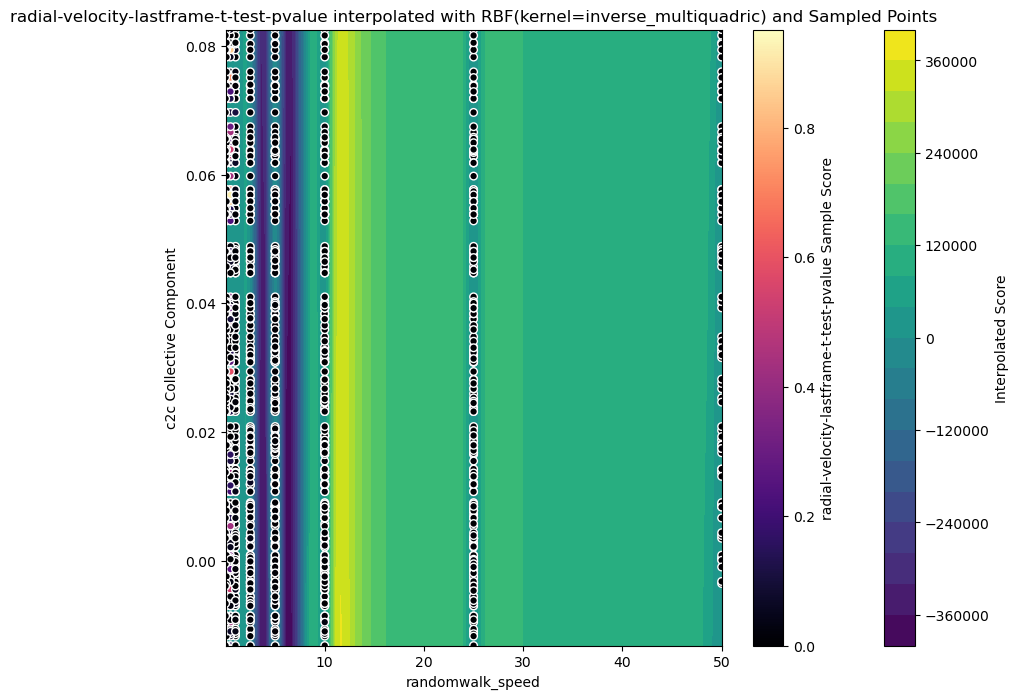

In [92]:
scorenames = ["zscores-normalized-sum", "zscores-lastframe-normalized-sum", "circularity-lastframe-mean", "infected-count-zscore-mean", "infected-count-lastframe-zscore-mean", "infected-count-lastframe-t-test-pvalue", "infected-count-corxi2-pval", "area-lastframe-zscore-mean", "area-lastframe-t-test-pvalue", "radial-velocity-lastframe-zscore-mean", "radial-velocity-lastframe-t-test-pvalue"]
for s in scorenames:
    plot_rbf_interpolator(s, method='inverse_multiquadric')  # methods: linear, thin_plate_spline, cubic, quintic, multiquadric, inverse_multiquadric

## Method: Polynomial

In [93]:
import numpy as np
from numpy.polynomial import Polynomial

def plot_polynomial_interpolator(scorename, deg=2, xlim=None, ylim=None):
    score = df[scorename].values
    X = np.vstack((rw_speed, c2c_c)).T
    # Generate a grid of points to interpolate the score over
    grid_x, grid_y = np.mgrid[rw_speed.min():rw_speed.max():100j, c2c_c.min():c2c_c.max():100j]

    # Create a 2D array to hold the polynomial coefficients
    coeffs = np.zeros((deg + 1, deg + 1))

    # Generate the terms for the polynomial fitting
    for i in range(deg + 1):
        for j in range(deg + 1):
            # Calculate the polynomial coefficients using least squares
            coeffs[i, j] = np.sum(score * (rw_speed**i) * (c2c_c**j)) / np.sum((rw_speed**i) * (c2c_c**j))
    
    # Define a function to evaluate the polynomial at grid points
    def polynomial_func(x, y, coeffs):
        p = np.zeros_like(x)
        for i in range(deg + 1):
            for j in range(deg + 1):
                p += coeffs[i, j] * (x ** i) * (y ** j)
        return p
    
    # Evaluate the polynomial on the grid
    interpolated_scores = polynomial_func(grid_x, grid_y, coeffs)

    # Create a 2D contour plot of the interpolated score
    plt.figure(figsize=(10, 8))
    
    # Contour plot with the first colormap
    contour = plt.contourf(grid_x, grid_y, interpolated_scores, levels=20, cmap='viridis')

    # Scatter plot with a second colormap based on score values
    scatter = plt.scatter(rw_speed, c2c_c, c=score, cmap='magma', s=30, edgecolor='white', alpha=1)

    # Add the first colorbar (for the contour plot)
    plt.colorbar(contour, label='Interpolated Score')

    # Add the second colorbar (for the scatter plot)
    cbar_scatter = plt.colorbar(scatter, label=scorename + ' Sample Score')
    
    # Customize plot details
    plt.title(scorename + ' interpolated with np.Polynomial(deg=' + str(deg) + ') and Sampled Points')
    plt.xlabel('randomwalk_speed')
    plt.ylabel('c2c Collective Component')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.show()

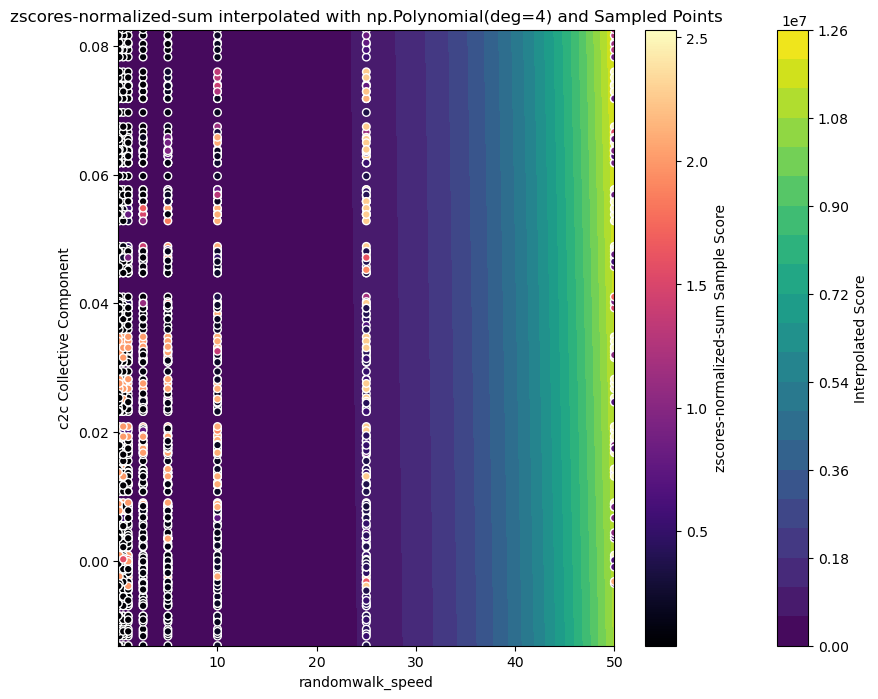

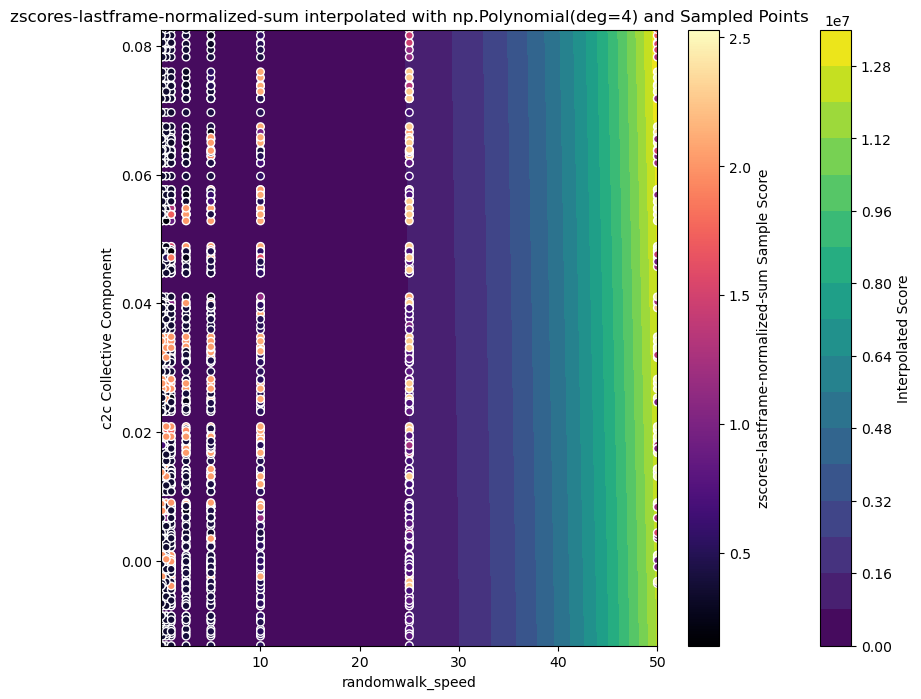

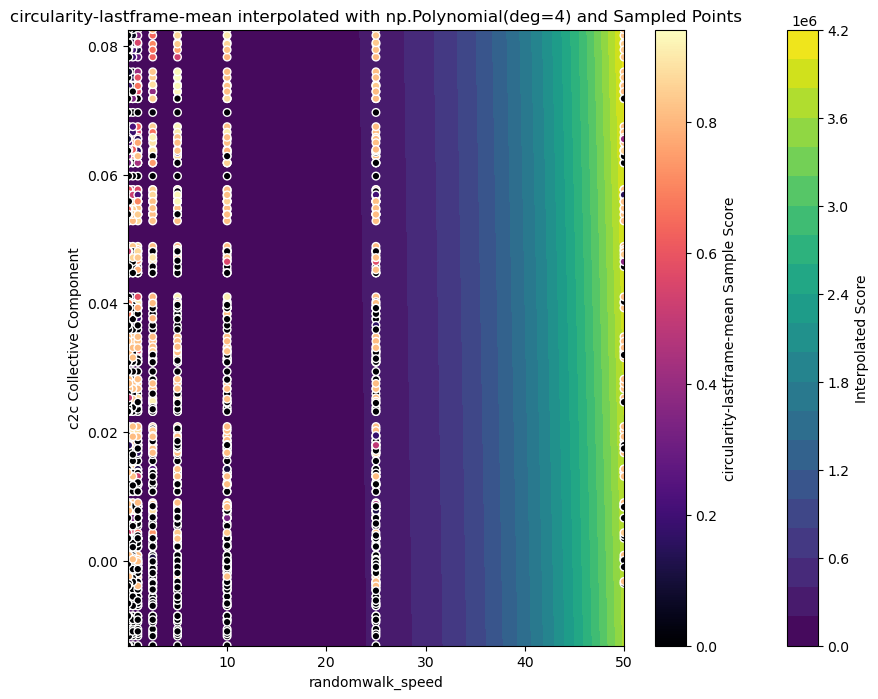

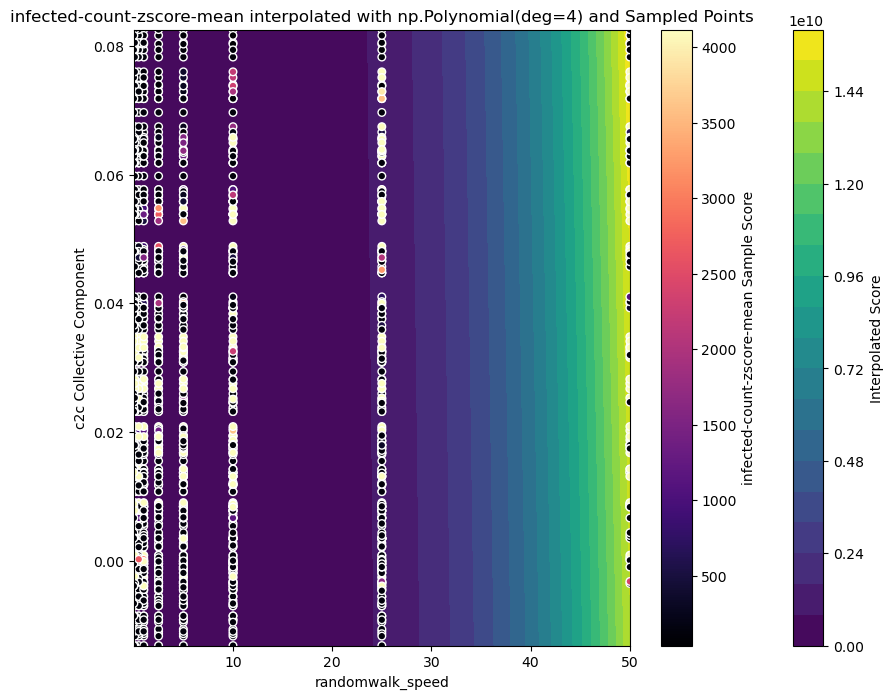

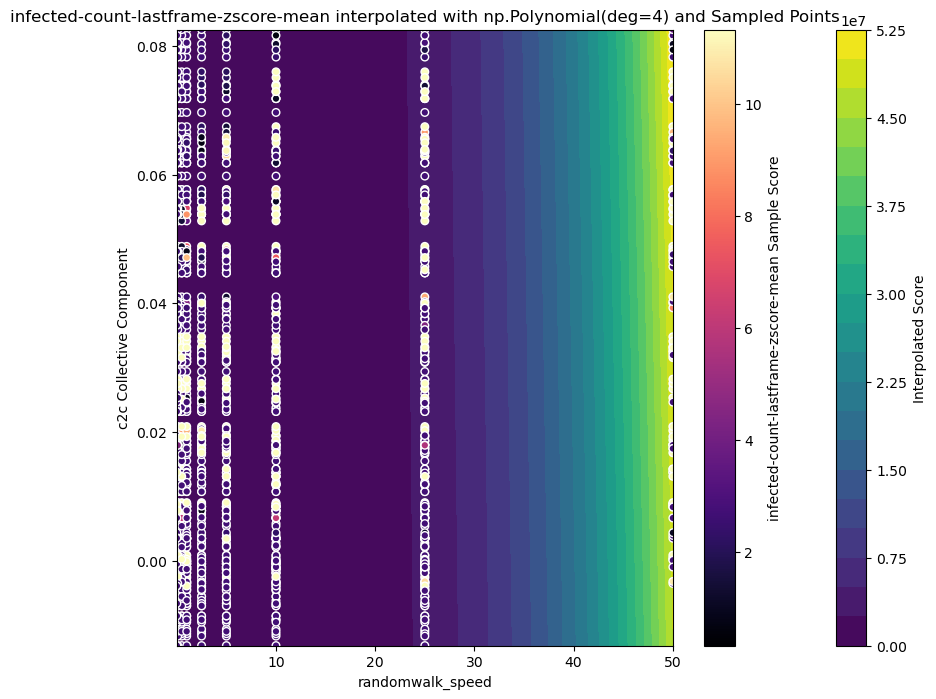

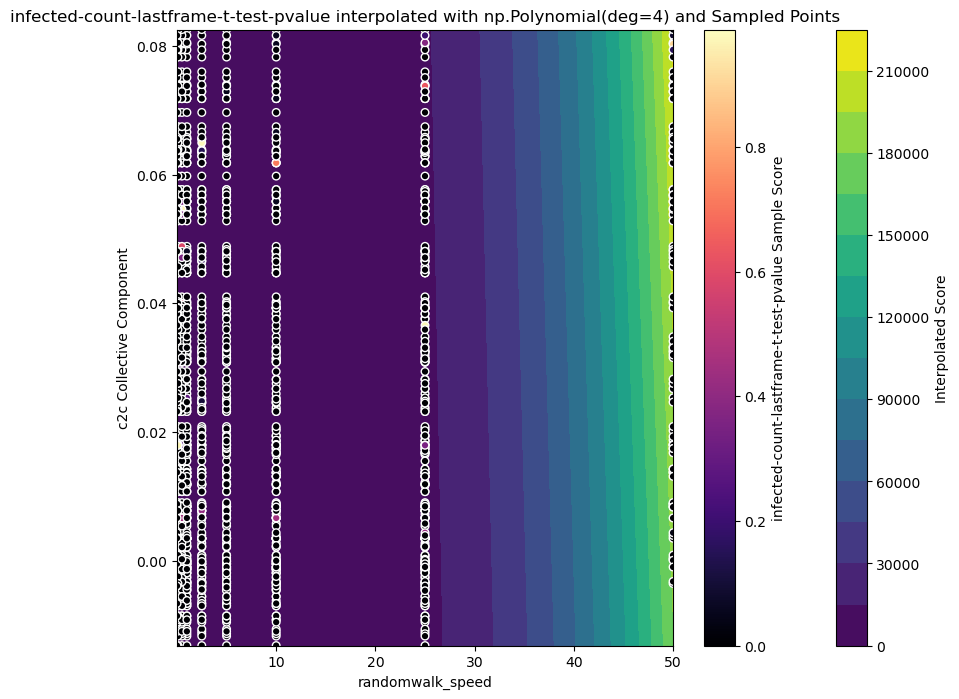

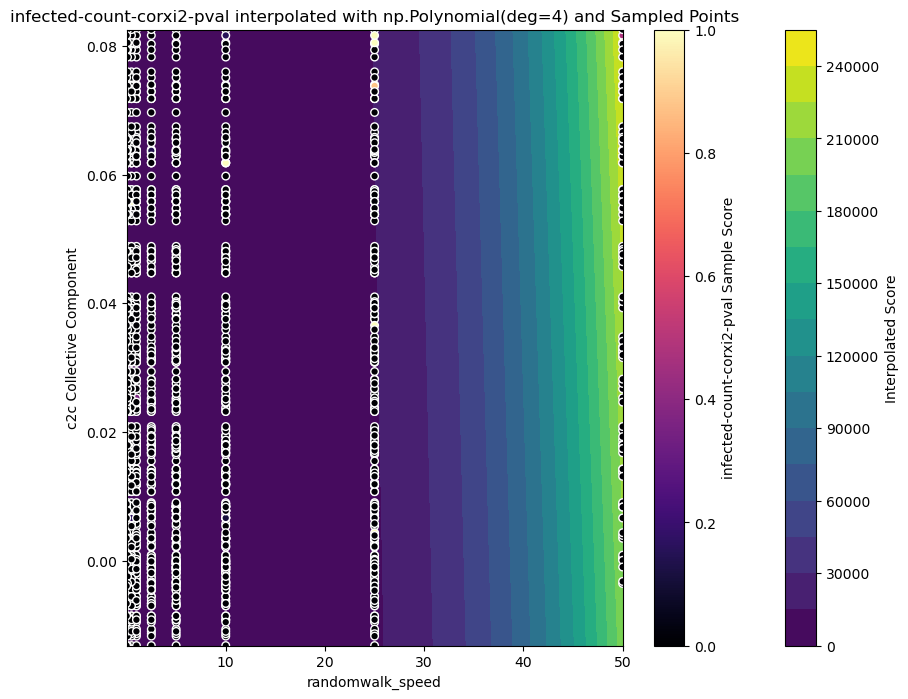

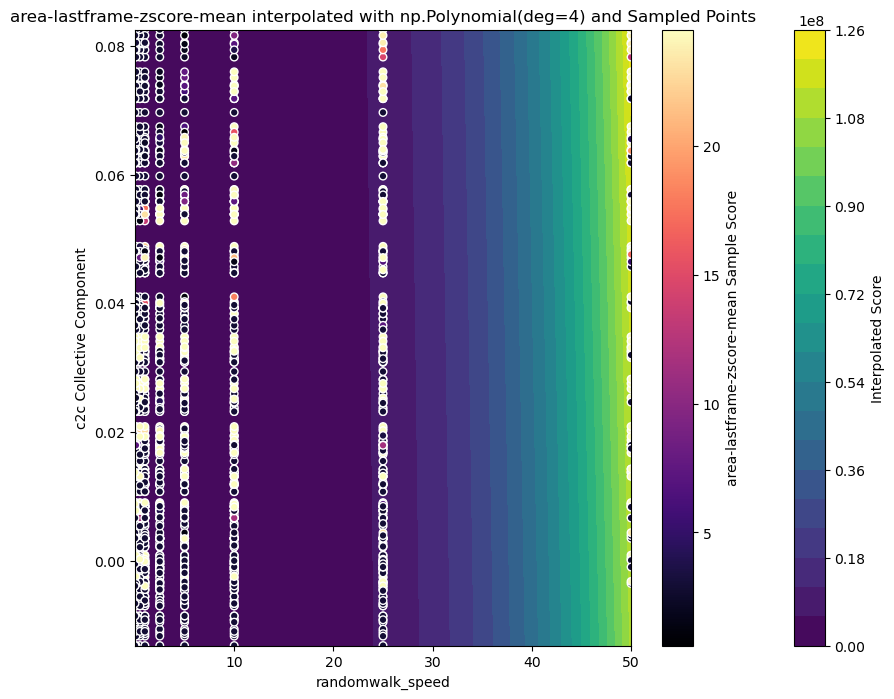

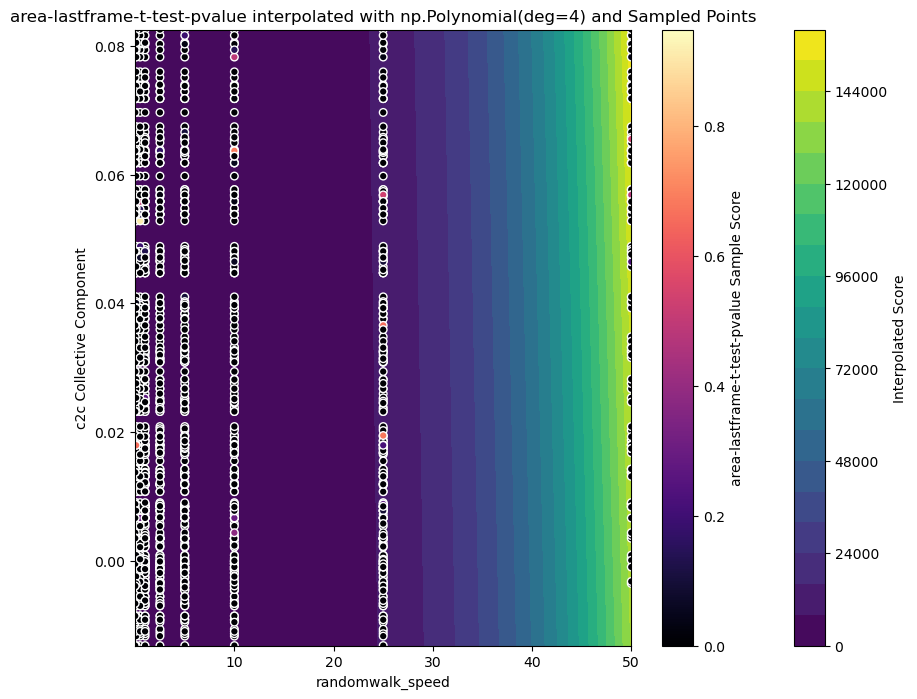

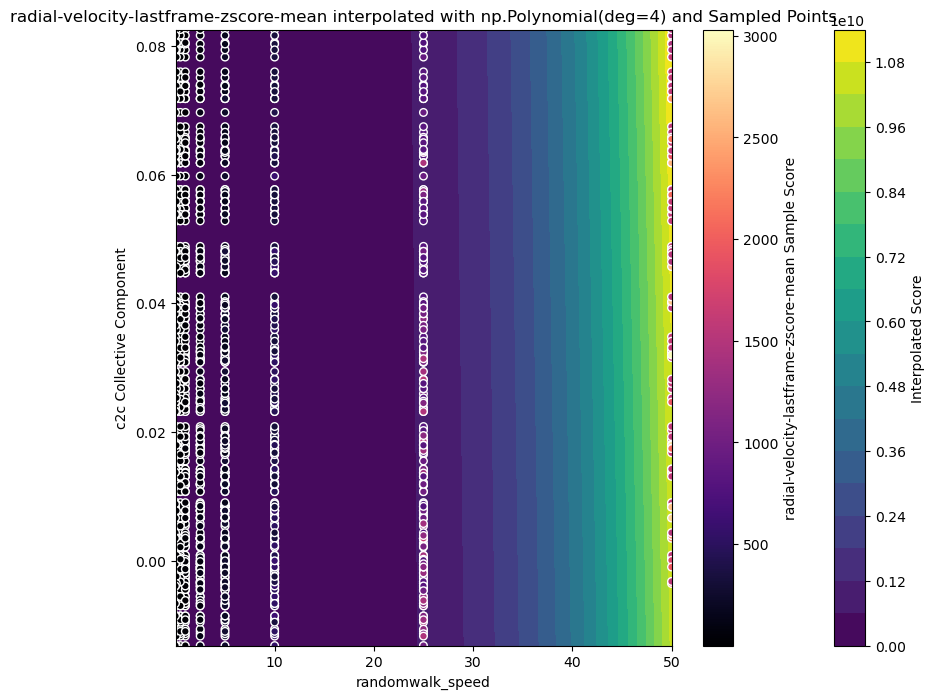

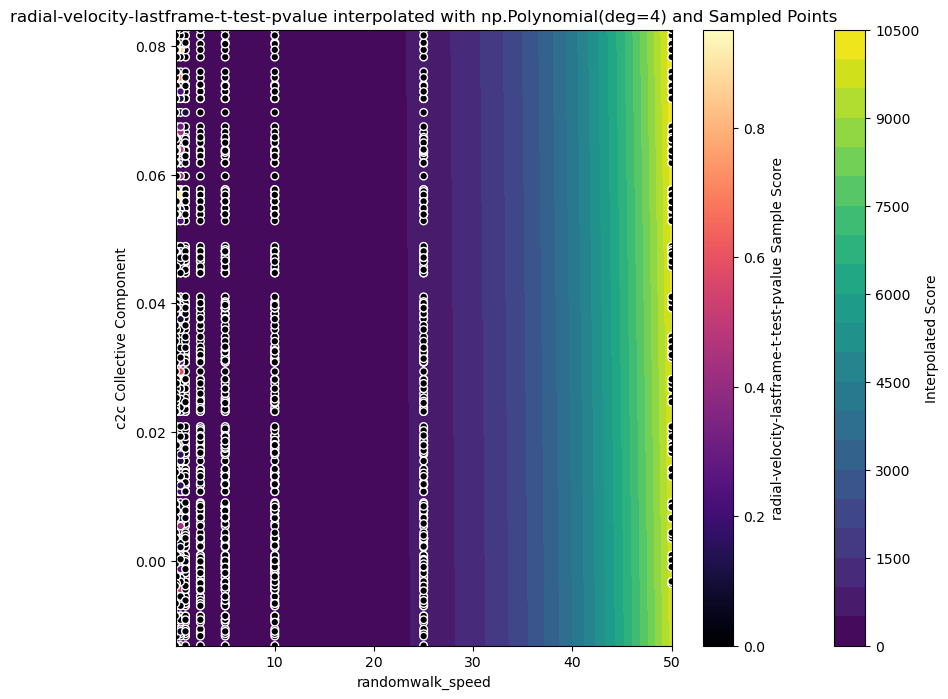

In [94]:
scorenames = ["zscores-normalized-sum", "zscores-lastframe-normalized-sum", "circularity-lastframe-mean", "infected-count-zscore-mean", "infected-count-lastframe-zscore-mean", "infected-count-lastframe-t-test-pvalue", "infected-count-corxi2-pval", "area-lastframe-zscore-mean", "area-lastframe-t-test-pvalue", "radial-velocity-lastframe-zscore-mean", "radial-velocity-lastframe-t-test-pvalue"]
for s in scorenames:
    plot_polynomial_interpolator(s, deg=4)

# Step 3: Inverse collective parameter

In [95]:

# Step 5: Define the inverse problem: find (x0, k, r) that match a given infection collective parameter
def inverse_infection_parameter(target_value):
    # Objective function to minimize (difference between predicted and target infection collective parameter)
    def objective(params):
        x0, k, r = params
        predicted = predict_infection_parameter(x0, k, r)
        return (predicted - target_value) ** 2  # We minimize the squared error

    # Initial guess for the optimization
    initial_guess = [np.mean(x0_values), np.mean(k_values), np.mean(r_values)]

    # Bounds for (x0, k, r)
    bounds = [(min(x0_values), max(x0_values)),
              (min(k_values), max(k_values)),
              (min(r_values), max(r_values))]

    # Perform the optimization to find the parameters
    result = minimize(objective, initial_guess, bounds=bounds)

    if result.success:
        return result.x  # Return the optimized parameters (x0, k, r)
    else:
        raise ValueError("Optimization failed!")

# Example of inverting the infection collective parameter to find (x0, k, r)
target_infection_param = 0.5
x0_inv, k_inv, r_inv = inverse_infection_parameter(target_infection_param)
print(f"Inverted values for infection collective parameter {target_infection_param}: x0={x0_inv}, k={k_inv}, r={r_inv}")


Inverted values for infection collective parameter 0.5: x0=0.0, k=0.0, r=0.0
